<a href="https://colab.research.google.com/github/johnhallman/tigercontrol/blob/tutorials/tutorials/notebooks/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Models: Pre-implemented Algorithms for Solving Problems


The Model class is the abstraction used to implement models/predictors for the problems. TigerControl is designed so that the Model and Problem classes can be combined in a modular fashion. Roughly speaking, the goal of TigerControl is to be able to test an arbitrary model on an arbitrary problem, at least when it makes sense to do so. The initialize method sets up the model with  given hyperparameters. The predict method returns the prediction for a given input. The update method updates the parameters of the model according to an optimizer, which is either stored as an attribute of the model or implemented manually in certain cases.



We start by installing and importing the base TigerControl package.

In [0]:
!git clone https://github.com/johnhallman/tigercontrol.git
!pip install -e tigercontrol

In [0]:
import tigercontrol
import jax.numpy as np
import matplotlib.pyplot as plt

# Time Series Models
For example, below we show how to combine a basic last-value model (a predictor that just outputs the previous observation) for time-series on the ARMA problem.

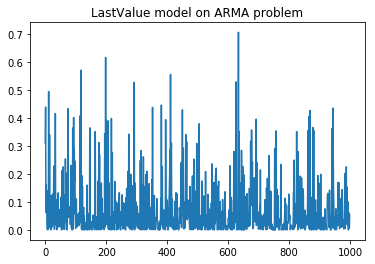

In [2]:
from tigercontrol.models.optimizers.losses import mse

T = 1000 
p, q = 3, 3
problem = tigercontrol.problem("ARMA-v0")
x = problem.initialize(p, q)

model = tigercontrol.model("LastValue")
model.initialize()

results = []
for i in range(T):
  y_pred = model.predict(x)
  y_true = problem.step()
  loss = mse(y_true, y_pred)
  results.append(loss)
  model.update(y_true)
  x = y_true

plt.plot(results)
plt.title("LastValue model on ARMA problem")
plt.show()

#Control Models
Next, we demonstrate the classical Kalman filter on a trivial dynamical system where the observation has constant value.

/usr/local/lib/python3.6/dist-packages/jax/numpy/linalg.py:119: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)
/usr/local/lib/python3.6/dist-packages/jax/numpy/linalg.py:211: UserWarning: numpy.linalg support is experimental and may cause silent failures or wrong outputs
  warnings.warn(_EXPERIMENTAL_WARNING)


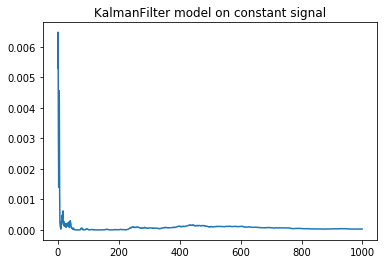

In [4]:
import jax.random as random
from tigercontrol.utils import generate_key

T = 1000 
x_true = 0.5
env_noise = 0.1
x0 = 0

model = tigercontrol.model("KalmanFilter")
model.initialize(x0, 1, 0, 1, 1, 0, env_noise)

results = []
for i in range(T):
  z = x_true + float(random.normal(generate_key(), shape = (1,)) * env_noise)
  x_pred = model.step(0, z)
  loss = mse(x_true, x_pred)
  results.append(loss)

plt.plot(results)
plt.title("KalmanFilter model on constant signal")
plt.show()

#Optimizers
Every model needs three core methods — initialize, predict, and update. Although initialize and predict can vary greatly between models, many use very similar update methods, for example in the form of traditional optimization algorithms such as stochastic gradient descent (SGD) or AdaGrad. TigerControl comes with preimplemented optimization algorithms that can be easily incorporated with JAX. Below, we demonstrate how to use the online gradient descent (OGD) optimizer on the AutoRegressor model by applying it to an ARMA(3, 0) problem.

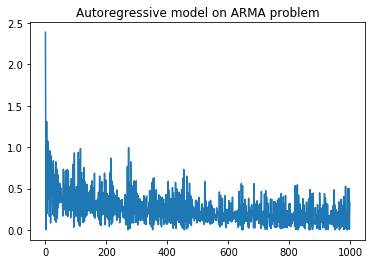

In [5]:
from tigercontrol.models.optimizers import OGD

T = 1000
p, q = 3, 0
problem = tigercontrol.problem("ARMA-v0")
x = problem.initialize(p, q)

# there are two ways to assign an optimizer to a problem...

model = tigercontrol.model("AutoRegressor")
model.initialize(p, optimizer=OGD) # either by providing the class as argument...

ogd = OGD(learning_rate=0.01) 
model.initialize(p, optimizer=ogd) # or by providing an optimizer instance

results = []
for i in range(T):
  y_pred = model.predict(cur_x)
  y_true = problem.step()
  loss = mse(y_pred, y_true)
  model.update(y_true)
  x = y_true
  results.append(loss)

plt.plot(results)
plt.title("Autoregressive model on ARMA problem")
plt.show()